In [24]:
import tensorflow as tf
import numpy as np
import subprocess
import sys, copy
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [52]:
'''
1&2. load couplings and mo_pair descriptor 
'''
raw_data = np.loadtxt('./data/results.csv', delimiter=',',comments='#')
raw_data_rot = np.loadtxt('./data/results_rot_2.csv', delimiter=',',comments='#')
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])
c_homo_rot = abs(raw_data_rot[:,3])
c_lumo_rot = abs(raw_data_rot[:,4])
c_homo_tr = np.concatenate((c_homo,c_homo_rot))
c_lumo_tr = np.concatenate((c_lumo,c_lumo_rot))

homo_pairs = np.load('./data/homo_homo_pair.npy')
lumo_pairs = np.load('./data/lumo_lumo_pair.npy')
homo_pairs_rot = np.load('./data/homo_pair_rot2.npy')
lumo_pairs_rot = np.load('./data/lumo_pair_rot2.npy')
homo_pairs_tr = np.concatenate((homo_pairs,homo_pairs_rot))
lumo_pairs_tr = np.concatenate((lumo_pairs,lumo_pairs_rot))

idx_rot = raw_data_rot[:,0:3]
mo_pairs = np.array([homo_pairs_rot[ii] for ii, i in enumerate(idx_rot) if i[1] == 12])
V = np.array([abs(raw_data_rot[:,3])[ii] for ii, i in enumerate(idx_rot) if i[1] == 12])
print(mo_pairs.shape)

(2116, 2, 8, 8)


In [48]:
'''
3. remove zero values
'''
ihzero = []
for ii,i in np.ndenumerate(V):
    if i<=0.00000000:
        ihzero.append(ii)
        V[ii] = 1e-9
print('Number of points to be deleted for homo:  ',len(ihzero))
mo_pairs  = np.delete(mo_pairs , ihzero, 0)
V  = np.delete(V , ihzero, 0)

Number of points to be deleted for homo:   18


In [55]:
# ilzero = []
# for ii,i in np.ndenumerate(c_lumo):
#     if i<=0.00000000:
#         ilzero.append(ii)
#         c_lumo[ii] = 1e-9
# print('Number of points to be deleted for lumo:  ',len(ilzero))
# lumo_pairs  = np.delete(lumo_pairs , ilzero, 0)
# c_lumo  = np.delete(c_lumo , ilzero, 0)

# '''
# 4. build training set
# '''
# train_homo_pairs = homo_pairs[:]
# train_lumo_pairs = lumo_pairs[:]

# train_c_homo = -np.log(c_homo)[:]
# train_c_lumo = -np.log(c_lumo)[:]

# train_homo = copy.deepcopy(train_homo_pairs)
# train_chomo = copy.deepcopy(train_c_homo)
# print('Size of full training set for homo:   ',len(train_chomo))
# index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)*0.1), replace=False)
# train_homo_ = np.delete(train_homo,index,0)
# train_chomo_ = np.delete(train_chomo,index,0)
# print('Size of selected training set for homo:   ',len(train_homo_))

# train_lumo = copy.deepcopy(train_lumo_pairs)
# train_clumo = copy.deepcopy(train_c_lumo)
# print('Size of full training set for lumo:   ',len(train_clumo))
# index = np.random.choice(len(train_c_lumo), size=int(len(train_c_lumo)*0.1), replace=False)
# train_lumo_ = np.delete(train_lumo,index,0)
# train_clumo_ = np.delete(train_clumo,index,0)
# print('Size of selected training set for lumo:   ',len(train_lumo_))

# '''
# 5. build testing set
# '''
# iall = np.arange(len(train_c_homo))
# idiff = np.setdiff1d(iall,index)
# test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
# test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

# iall = np.arange(len(train_c_lumo))
# idiff = np.setdiff1d(iall,index)
# test_lumo = np.delete(copy.deepcopy(train_lumo_pairs),idiff,0)
# test_clumo = np.delete(copy.deepcopy(train_clumo),idiff,0)

'''
6. load model
'''
model_path = './trained_model/rot/nat_dimer_homo_rot_17844/model/'
model = tf.keras.models.load_model(model_path, compile=False)
pred = np.exp(-model(mo_pairs, training=False).numpy().reshape((len(mo_pairs),)))

print(np.mean(np.multiply(abs(np.log(pred)-np.log(V)), np.power(-np.log(V),-1))*100))
error1 = np.mean(np.multiply(abs(pred-V), np.power(V,-1))*100)
error2 = np.mean(abs(pred-V)*1000*27.2114)
print('MAPE: ',error1, '\nMAE(meV): ',error2)

nan
MAPE:  inf 
MAE(meV):  33.19776047625592


/home/dgg95223/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/dgg95223/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/home/dgg95223/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in power


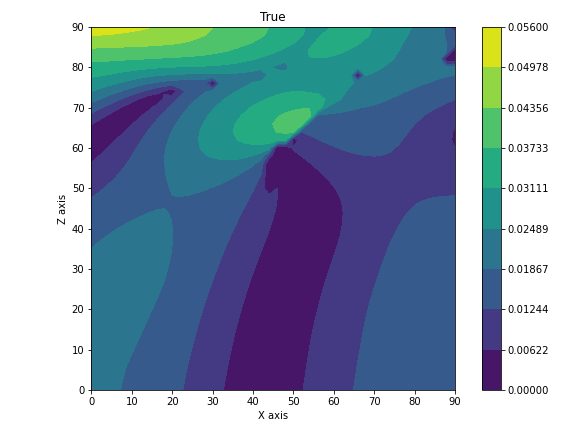

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
x = np.linspace(0, 90, 46)
y = np.linspace(0, 90, 46)
# Z = -train_c_homo.reshape((41,41))
Z = V.reshape((46,46))
l = np.linspace(0,0.056,10)
fig1, ax1 = plt.subplots(figsize=(8,6))
a1 = ax1.contourf(x,y, Z.T, levels=l)
ax1.set_title('True')
ax1.set_aspect('equal')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Z axis')
fig1.colorbar(a1)
plt.tight_layout()

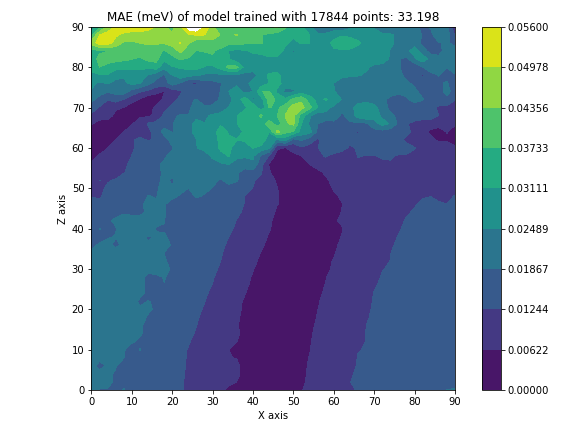

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
x = np.linspace(0, 90, 46)
y = np.linspace(0, 90, 46)
# Z = -train_c_homo.reshape((41,41))
Z = pred.reshape((46,46))

fig1, ax1 = plt.subplots(figsize=(8,6))
a1 = ax1.contourf(x,y, Z.T, levels=l)
ax1.set_title('MAE (meV) of model trained with 17844 points: %5.3f'%error2)
ax1.set_aspect('equal')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Z axis')
fig1.colorbar(a1)
plt.tight_layout()